In [2]:
# %auto reload(module)
%load_ext autoreload
%autoreload 2
from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
import warnings
import pandas as pd
import neurokit2 as nk ## package for simulation of ECG signals
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))
from multi_modal_heart.ECG.ecg_utils import get_simulated_ecg, arraytodataframe, plot_ecg_frame, detect_r_peaks_from_multiple_lead,detect_r_peaks_from_single_lead,distort_multi_lead_signals,mask_signal,standardize_multi_lead_ecg
%matplotlib inline
## original dataset loader
from multi_modal_heart.ECG.ecg_dataset import ECGDataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


          I        II       III       aVR       aVL       aVF        V1  \
0  1.110930  0.584566  0.529774  0.653338  1.050230  0.459117  1.149297   
1  0.849543  0.544131  0.612851  0.752083  0.790460  0.468250  1.065450   
2  0.320777  0.467148  0.789592  0.958244  0.268426  0.493879  0.901179   
3 -0.147249  0.400080  0.947304  1.128248 -0.184873  0.515070  0.743209   
4 -0.374801  0.365669  1.021134  1.202022 -0.402217  0.521606  0.658605   

         V2        V3        V4        V5        V6  
0  0.939189  1.096474  1.161083  1.191822  0.992227  
1  0.714661  0.848737  0.910651  0.968487  0.864149  
2  0.251181  0.338598  0.395044  0.518248  0.617851  
3 -0.182580 -0.141217 -0.089654  0.118084  0.421883  
4 -0.398822 -0.382248 -0.332584 -0.076753  0.330978  
(1000, 12)


Text(0.5, 0.98, 'Original ECG signal')

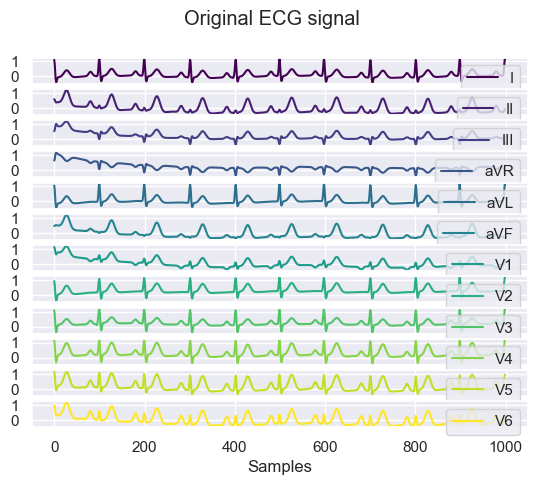

In [3]:
# Generate original signal
original_multi_df = nk.ecg_simulate(duration=10, heart_rate=60,method="multileads",sampling_rate=100, length=1000,random_state=42)
# original_multi_df = nk.ecg_simulate(duration=10, heart_rate=80,method="multileads",sampling_rate=100, length=1000,method="ai")
# original_multi_df = nk.ecg_simulate(duration=10, heart_rate=100,method="multileads",sampling_rate=100, length=1000)

np.array(original_multi_df).shape
print(original_multi_df.head(5))
print (original_multi_df.shape)
nk.signal_plot(original_multi_df, subplots=True)
plt.suptitle("Original ECG signal")


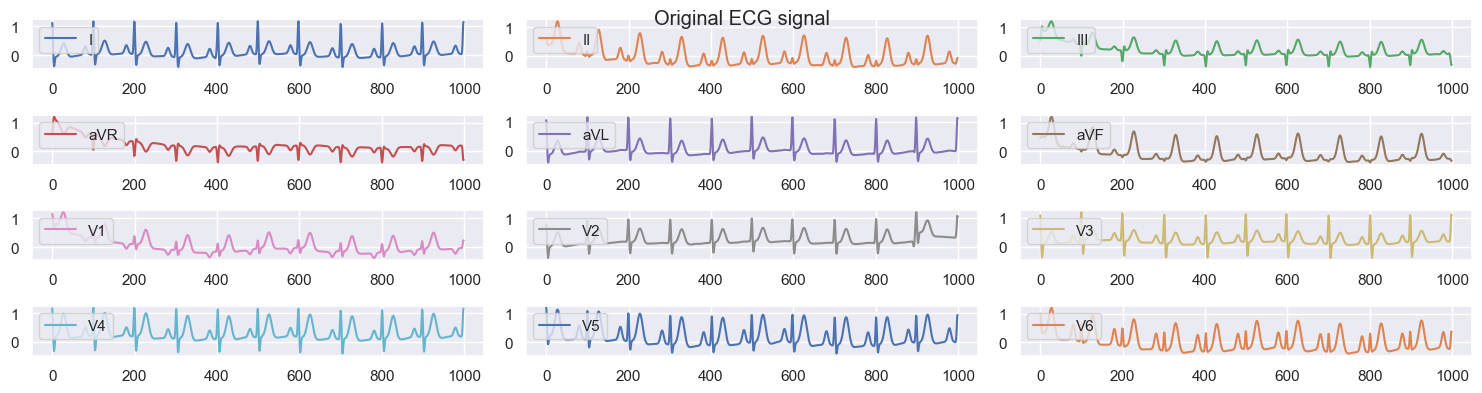

In [4]:

## two ways of visualization
plt, axes  = plot_ecg_frame(original_multi_df, title="Original ECG signal",figsize=(15,4),figure_arrangement=(4,3))


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/neurokit2/signal/signal_distort.py:301: NeuroKitWarning: Skipping requested noise frequency  of 100 Hz since it cannot be resolved at  the sampling rate of 500 Hz. Please increase  sampling rate to 1000 Hz or choose  frequencies smaller than or equal to 50.0 Hz.
  warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/neurokit2/signal/signal_distort.py:301: NeuroKitWarning: Skipping requested noise frequency  of 150 Hz since it cannot be resolved at  the sampling rate of 500 Hz. Please increase  sampling rate to 1500 Hz or choose  frequencies smaller than or equal to 50.0 Hz.
  warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/neurokit2/signal/signal_distort.py:301: NeuroKitWarning: Skipping requested noise frequency  of 175 Hz since it cannot be resolved at  the sampling rate of 500 Hz. Please increase  sampling rate to 1750 Hz or choose  frequencies smaller than or equ

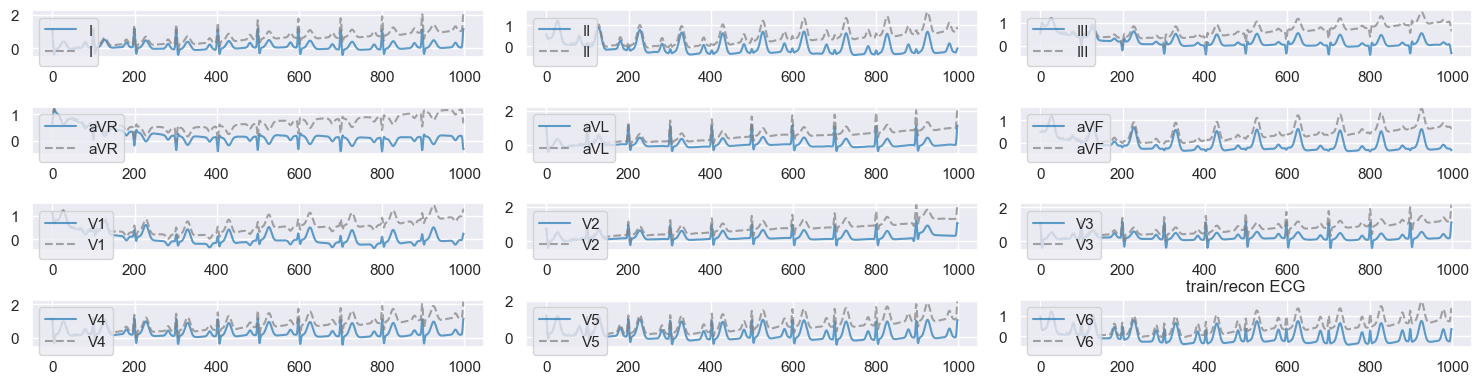

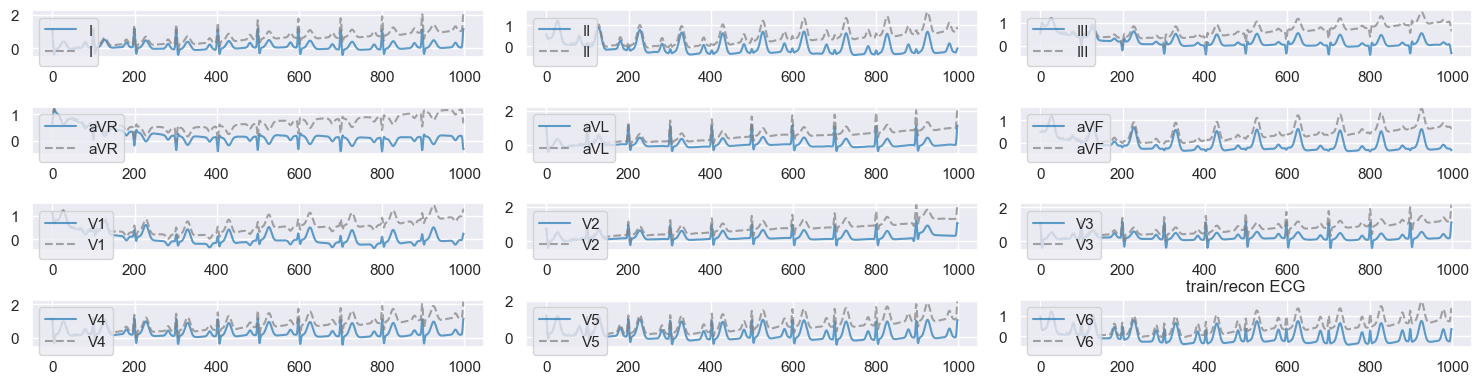

In [5]:
from multi_modal_heart.ECG.ecg_utils import plot_multiframe_in_one_figure
ecg_12_lead_signal_distored = distort_multi_lead_signals(np.array(original_multi_df.T),sampling_rate=500,noise_amplitude=0.01,random_prob=1)
# original_multi_df.columns = ["clean "+k for k in ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']]
second_data_frame = arraytodataframe(ecg_12_lead_signal_distored)
# second_data_frame.columns = ["noisy "+k for k in ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']]
plot_multiframe_in_one_figure([original_multi_df,second_data_frame], figsize=(15,4),figure_arrangement=(4,3))


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


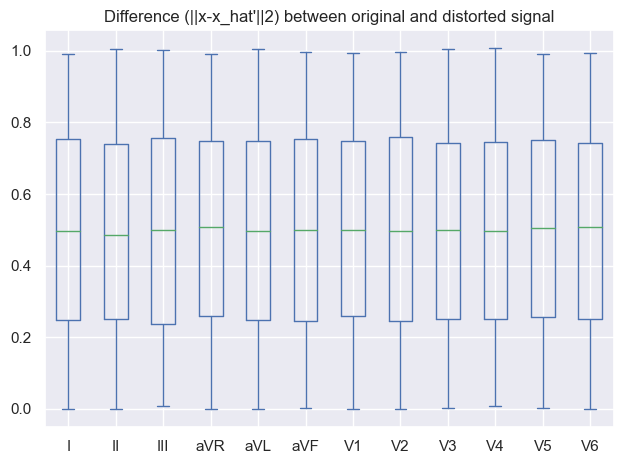

In [6]:
diff = np.sqrt(second_data_frame-original_multi_df)**2
err = (second_data_frame-original_multi_df).std(axis=0)
df1 = original_multi_df
df2 =second_data_frame
assert df1.shape == df2.shape, "The shape of the two dataframe should be the same"
assert df1.columns.all() == df2.columns.all(), "The column of the two dataframe should be the same"
 
diff.plot.box(title="Difference (||x-x_hat'||2) between original and distorted signal")
plt.tight_layout()


## Apply random noise


## Compare different r peak algorithm on clean simulated data

/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['zong error: index 1000 is out of bounds for axis 0 with size 1000']


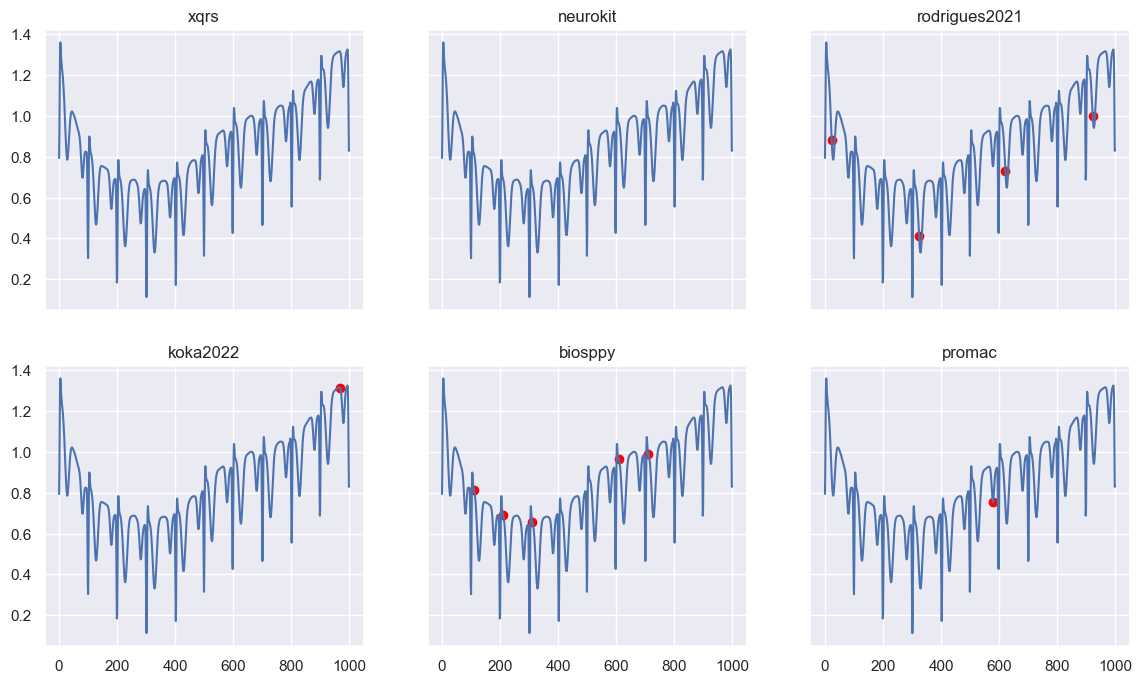

In [7]:
original = ecg_12_lead_signal_distored[3]+np.random.rand()
## test neural kit 
method_name_list=["xqrs","neurokit","rodrigues2021","koka2022","biosppy","promac"]
method_r_peak ={}
for method in method_name_list:
    my_r_peak = detect_r_peaks_from_single_lead(original,sampling_rate=500, method = method, if_clean=True)
    method_r_peak [method] = my_r_peak

fig, axes = plt.subplots(2, len(method_r_peak.keys())//2, figsize=(14, 8), sharex=True, sharey=True)
cur_index = 0
for i in range(2):
    for j in range(len(method_r_peak.keys())//2):
        axes[i,j].plot(original)
        ## add red point to the data frame
        # Add a red point
        method_name = method_name_list[cur_index]
        r_peak = method_r_peak[method_name]
        for x in r_peak:
            axes[i,j].scatter(x, original[x], color='red')  # Plotting a red point at index 2
        cur_index +=1
        axes[i,j].set_title(method_name)


## perform r peak detection on noisy data


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['zong error: index 1000 is out of bounds for axis 0 with size 1000']


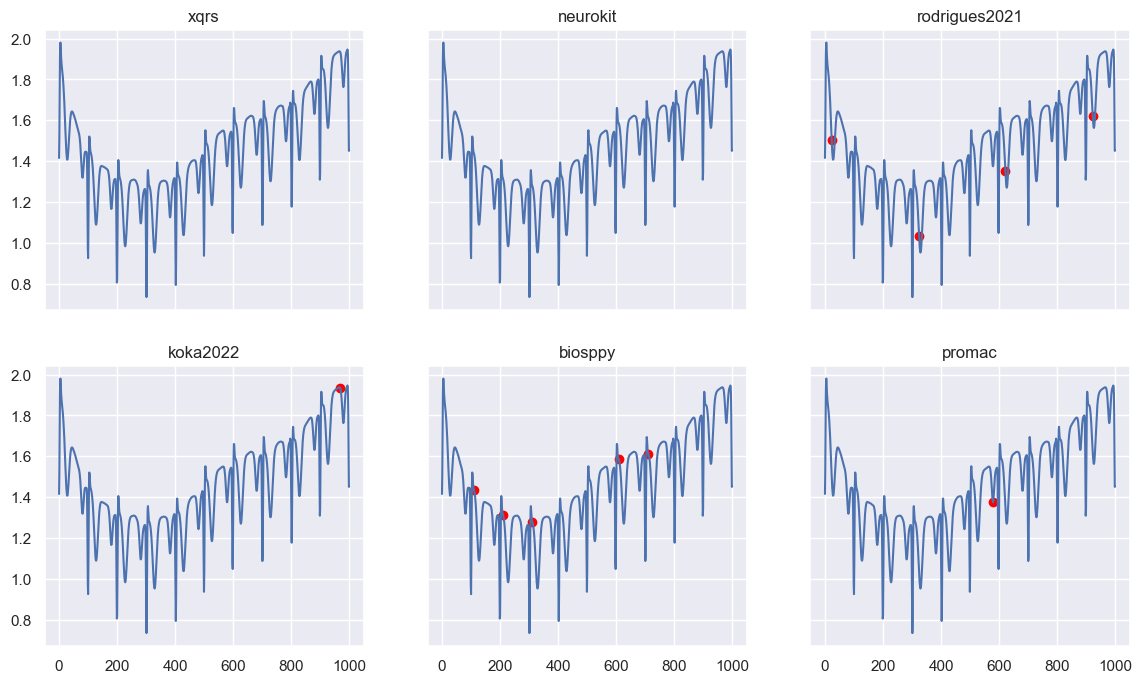

In [8]:
## perform r peak detection on distorted signal:
original = ecg_12_lead_signal_distored[3]+np.random.rand()
## test neural kit 
method_name_list=["xqrs","neurokit","rodrigues2021","koka2022","biosppy","promac"]
method_r_peak ={}
for method in method_name_list:
    my_r_peak = detect_r_peaks_from_single_lead(original,sampling_rate=500, method = method, if_clean=True)
    method_r_peak [method] = my_r_peak

fig, axes = plt.subplots(2, len(method_r_peak.keys())//2, figsize=(14, 8), sharex=True, sharey=True)
cur_index = 0
for i in range(2):
    for j in range(len(method_r_peak.keys())//2):
        axes[i,j].plot(original)
        ## add red point to the data frame
        # Add a red point
        method_name = method_name_list[cur_index]
        r_peak = method_r_peak[method_name]
        for x in r_peak:
            axes[i,j].scatter(x, original[x], color='red')  # Plotting a red point at index 2
        cur_index +=1
        axes[i,j].set_title(method_name)


['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['gamboa error: index -1 is out of bounds for axis 0 with size 0', 'zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['gamboa error: index -1 is out of bounds for axis 0 with size 0', 'zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['zong error: index 1000 is out of bounds for axis 0 with size 1000']
['neurokit error: index 0 is out of bounds for axis 0 with size 0', 'zong error: index 1000 is out

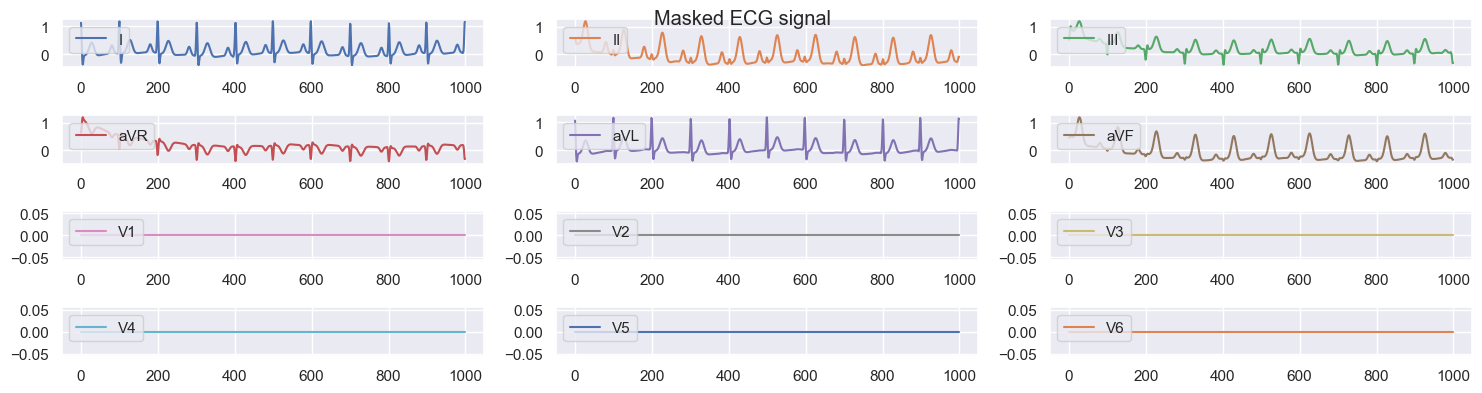

(<module 'matplotlib.pyplot' from '/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

In [9]:
## apply random masking over detected r peaks
critical_points = detect_r_peaks_from_multiple_lead(np.array(original_multi_df.T),sampling_rate=500, method = "promac", if_clean=True)
signal_array  = np.array(original_multi_df.T)
masked_signals, mask= mask_signal(signal_array, critical_points,mask_whole_lead_prob =1,lead_mask_prob = 0.5,region_mask_prob=0.1, mask_length_range=[0.08, 0.18], mask_value=0)
plot_ecg_frame(arraytodataframe(masked_signals), title="Masked ECG signal",figsize=(15,4),figure_arrangement=(4,3))

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,(1/2)(I-II)
0,1.118391,0.585464,0.529792,0.646211,1.060298,0.460290,1.150239,0.775554,1.096886,1.165505,1.191818,0.992229,0.266463
1,0.855648,0.545087,0.612867,0.746244,0.798723,0.469409,1.067931,0.578475,0.850133,0.916561,0.968484,0.864153,0.155280
2,0.324139,0.468215,0.789603,0.955092,0.273064,0.494997,0.906674,0.171656,0.342018,0.404020,0.518246,0.617856,-0.072038
3,-0.146315,0.401244,0.947311,1.127313,-0.183383,0.516155,0.751603,-0.209075,-0.135892,-0.077799,0.118082,0.421890,-0.273779
4,-0.375047,0.366882,1.021139,1.202049,-0.402236,0.522680,0.668551,-0.398875,-0.375966,-0.319287,-0.076754,0.330986,-0.370965


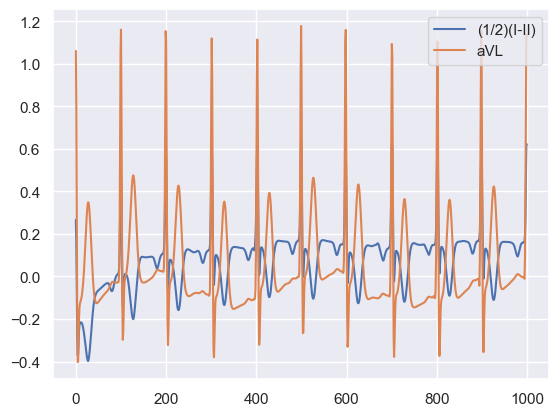

In [10]:
# PTB_XL_df = arraytodataframe(batch["cleaned_seq"][0])
PTB_XL_df = original_multi_df
# aVL = (I-II)/2
PTB_XL_df["(1/2)(I-II)"] = 1/2.0*(PTB_XL_df["I"]-PTB_XL_df["II"])
fig = PTB_XL_df["(1/2)(I-II)"].plot()
PTB_XL_df["aVL"].plot(ax=fig,label="aVL")
plt.legend()
PTB_XL_df.head()

0.9880979789845099


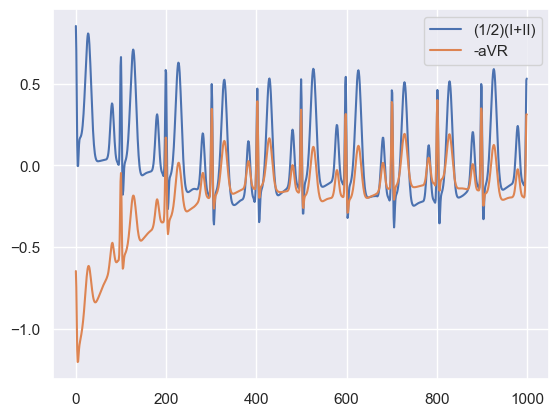

In [11]:
## aVR = -(I+II)/2
PTB_XL_df["(1/2)(I+II)"] = 1/2.0*(PTB_XL_df["I"]+PTB_XL_df["II"])
fig = PTB_XL_df["(1/2)(I+II)"].plot()
(-PTB_XL_df["aVR"]).plot(ax=fig,label="-aVR")
plt.legend()
score = distance.cosine(np.array(PTB_XL_df["(1/2)(I+II)"]),np.array(-PTB_XL_df["aVR"]))
print(score)

0.12102800405187653


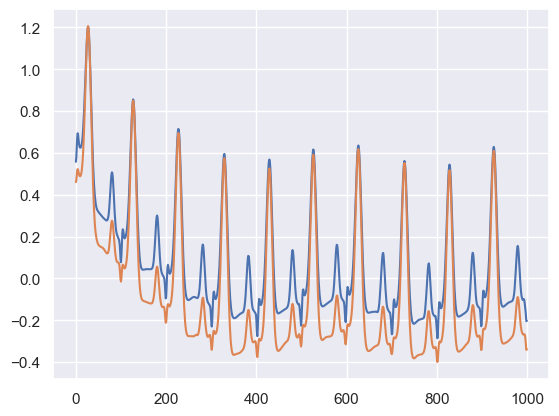

In [12]:
## aVF = (II+III)/2
from scipy.spatial import distance

PTB_XL_df["(1/2)(II+III)"] = 1/2.0*(PTB_XL_df["II"]+PTB_XL_df["III"])
fig = PTB_XL_df["(1/2)(II+III)"].plot()
PTB_XL_df["aVF"].plot(ax=fig,label="aVF")

score = distance.cosine(np.array(PTB_XL_df["(1/2)(II+III)"]),np.array(PTB_XL_df["aVF"]))
print(score)

In [65]:
from multi_modal_heart.model.custom_loss import SoftDTW,cal_dtw_loss
import torch
from tslearn import metrics

a = np.array(PTB_XL_df["(1/2)(II+III)"]) ## 1000,
b = np.array(PTB_XL_df["aVF"]) ## 1000,
print (a.shape)
a = torch.from_numpy(a[None,:,None]).float().cuda() ## N*1000*1
b = torch.from_numpy(b[None,:,None]).float().cuda() ## N*1000*1

loss = SoftDTW(use_cuda=True)(a,b)
print ("loss,",loss)
random_value= torch.randn(1,1,1000,dtype=torch.float32).cuda()
dtw_loss  = cal_dtw_loss(a.permute(0,2,1),random_value)
print ("dtw_loss,",dtw_loss)

a_1d_arr = a.reshape(-1,1).cpu().numpy()
b_1d_arr = b.reshape(-1,1).cpu().numpy()
path, sim = metrics.dtw_path(a_1d_arr, a_1d_arr)
print ("score",sim)

from multi_modal_heart.common.metrics import cal_multi_lead_dtw,cal_batch_multi_lead_dtw
print(cal_multi_lead_dtw(a_1d_arr.T,b_1d_arr.T,reduction=False))
print ("score",sim)


(1000,)
loss, tensor([-1692.2257], device='cuda:0')
dtw_loss, tensor(16.2083, device='cuda:0')
score 0.0
[2.6679713766426834]
score 0.0


In [49]:
a =[1,2,3]
b = [1,2,3]
## element wise sum for two lists
a = np.array(a)
b = np.array(b)
print (a+b)

[2 4 6]


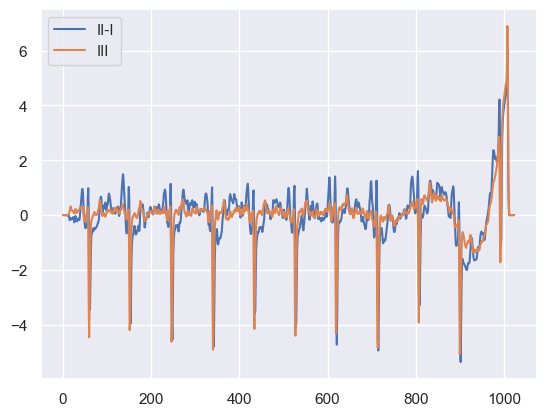

In [25]:
PTB_XL_df["II-I"] = (PTB_XL_df["II"]-PTB_XL_df["I"])
fig = PTB_XL_df["II-I"].plot()
PTB_XL_df["III"].plot(ax=fig,label="III")
plt.legend()


In [28]:
from scipy.spatial import distance

distance.cosine(np.array(PTB_XL_df["II-I"]),np.array(PTB_XL_df["III"]))

0.2207779884338379

In [ ]:
def mel_filters(device, n_mels: int = 80, mel_filter_path="./assets/mel_filters.npz") -> torch.Tensor:
    """
    load the mel filterbank matrix for projecting STFT into a Mel spectrogram.
    Allows decoupling librosa dependency; saved using:

        np.savez_compressed(
            "mel_filters.npz",
            mel_80=librosa.filters.mel(sr=16000, n_fft=400, n_mels=80),
        )
    """
    assert n_mels == 80, f"Unsupported n_mels: {n_mels}"
    with np.load(
        mel_filter_path
    ) as f:
        return torch.from_numpy(f[f"mel_{n_mels}"]).to(device)



In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

N_FFT = 198
## # Apply a Fourier transform to convert the ECG signal to the frequency domain
waveform = torch.from_numpy(signal_array[:1024]).float()
# Plot the spectrogram
fig,axes = plt.subplots(waveform.size(0)//3,3, figsize=(16,4))
axes = axes.flatten()

for i in range(waveform.size(0)):
    window = torch.hann_window(N_FFT).to(waveform.device)
    spectrum = torch.stft(waveform[i], n_fft=N_FFT, hop_length=None,return_complex=True,win_length=None)

    magnitudes = spectrum[..., :-1].abs() ** 2

    log_spec = torch.clamp(magnitudes, min=1e-10).log10()
    print (log_spec.shape) ## 80,50
    axes[i].imshow(log_spec.detach().numpy(), aspect='auto', origin='lower')
    axes[i].grid(None)
    # axes[i].set_xlabel('Time')
    # axes[i].set_ylabel('Frequency')
    # axes[i].colorbar(format='%+2.0f dB')
    # axes[i].title('ECG Spectrogram')
    # axes[i].show()


In [ ]:
## template signal

In [ ]:
## apply standardization
preprocessed_ecg = standardize_multi_lead_ecg(masked_signals,sampling_rate=500,if_clean=True)
plot_ecg_frame(arraytodataframe(preprocessed_ecg), title="Standardized ECG signal",figsize=(15,4),figure_arrangement=(4,3))

In [ ]:
## 

In [ ]:

# Create an instance of the ECGDataset class
dataset = ECGDataset(data_root = "/home/engs2522/project/lib/ECG/ecg_ptbxl_benchmarking/data/ptbxl/",
                     label_csv_path ="/home/engs2522/project/lib/ECG/ptbxl_feature_benchmark/data/organized/high_quality/train_statement.csv",
                     sampling_rate=500, ## ecg sampling rate
                     max_seq_len = 1024,
                     data_proc_config={
                        "if_clean":True,
                        },
                     augmentation=True,
                     data_aug_config={
                    "noise_frequency_list":[5,10,50],
                    "noise_amplitude_range":[0.,0.2],
                     "powerline_frequency_list":[50],
                    "powerline_amplitude_range":[0.,0.05],
                    "artifacts_amplitude_range":[0.,0.1],
                    "artifacts_number_range":[0,3],
                    "linear_drift_range":[0.,0.3],
                    "random_prob":0.5,
                    "if_mask_signal":False,
                    "mask_whole_lead_prob":0.1,
                    "lead_mask_prob":0.2,
                    "region_mask_prob":0.15,
                    "mask_length_range":[0.08, 0.18],
                    "mask_value":0.0,
                    "artifacts_frequency_list":[5,10],
                    }
                       
                    )

# Test the __len__ method
print (len(dataset))

# Test the __getitem__ method
data_dict = dataset[12]
data_dict.keys()
## get input and target
input_seq = data_dict["input_seq"]
target_seq = data_dict["cleaned_seq"]

print(input_seq.shape)
print(target_seq.shape)
plot_ecg_frame(arraytodataframe(input_seq.squeeze(1)[:3]), title="Input ECG signal",figsize=(5,3),figure_arrangement=(1,3))
plot_ecg_frame(arraytodataframe(target_seq.squeeze(1)[:3]), title="reference ECG signal",figsize=(5,3),figure_arrangement=(1,3))
if "next_seq" in data_dict.keys():
    next_seq = data_dict["next_seq"]
    plot_ecg_frame(arraytodataframe(next_seq.squeeze(1)[:3]), title="next ECG signal",figsize=(5,3),figure_arrangement=(1,3))

In [18]:
## start training
import os
from torch.utils.data import DataLoader

## initialize a dataloader 
data_folder = "/home/engs2522/project/multi-modal-heart/multi_modal_heart/data/ptbxl/"
train_data_statement_path = os.path.join(data_folder,"/home/engs2522/project/multi-modal-heart/multi_modal_heart/data/ptbxl/high_quality_split/Y_train.csv")
validate_data_statement_path = os.path.join(data_folder,"/home/engs2522/project/multi-modal-heart/multi_modal_heart/data/ptbxl/high_quality_split/Y_validate.csv")
test_data_statement_path = os.path.join(data_folder,"/home/engs2522/project/multi-modal-heart/multi_modal_heart/data/ptbxl/high_quality_split/Y_test.csv")


data_loaders = []
sampling_rate=100
batch_size  = 128
max_seq_len = 1024
data_proc_config={
                "if_clean":True,
                 }
data_aug_config={
                "noise_frequency_list":[5,20,100,150,175],
                "noise_amplitude_range":[0.,0.2],
                "powerline_frequency_list":[50],
                "powerline_amplitude_range":[0.,0.05],
                "artifacts_amplitude_range":[0.,0.1],
                "artifacts_frequency_list":[5,10],
                "artifacts_number_range":[0,3],
                "linear_drift_range":[0.,0.1],
                "random_prob":0.5,
                "if_mask_signal":False,
                "mask_whole_lead_prob":0.2,
                "lead_mask_prob":0.2,
                "region_mask_prob":0.15,
                "mask_length_range":[0.08, 0.18],
                "mask_value":0.0
                }
for label_csv_path in [train_data_statement_path,validate_data_statement_path,test_data_statement_path]:
    if_test ="test" in label_csv_path.split("/")[-1]
    dataset = ECGDataset(data_folder,label_csv_path=label_csv_path,
                          sampling_rate=sampling_rate,
                          max_seq_len=max_seq_len,
                          augmentation= not if_test,
                          data_proc_config=data_proc_config,
                          data_aug_config=data_aug_config,)
    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle = not if_test,
                            drop_last= not if_test,
                            )
    print ('load {} data: {} samples'.format(label_csv_path.split("/")[-1],len(dataset)))
    data_loaders.append(data_loader)
    
train_loader, validate_loader, test_loader = data_loaders[0],data_loaders[1],data_loaders[2]

load Y_train.csv data: 4462 samples
load Y_validate.csv data: 545 samples
load Y_test.csv data: 527 samples


## Build ECG network

In [35]:
from multi_modal_heart.model.ecg_net import ECGAE
import torch
import torch.nn as nn
## configuration 0:
    ## input: 12 leads, 1024 time steps
## configuration 1:
    ## input: 12 leads, 1024 time steps, with time encoding
## configuration 2:
    ## input: 12 leads, 256 time steps, with time encoding, 4 time steps per second
## plain autoencoder
ecg_net= ECGAE(encoder_type ="ms_resnet",in_channels=12,ECG_length=1024,embedding_dim=256,latent_code_dim=64,add_time=True,apply_method="fixed_positional_encoding",decoder_outdim=24,time_dim=4,act = nn.ELU())
encoder_vec = ecg_net.encodeECG(torch.randn(4,12,1024),mask = torch.randn(4,12,1024),auto_pad_input=True)
print (encoder_vec.shape)
decoder_vec = ecg_net.decodeECG(encoder_vec)
print (decoder_vec.shape)

input dim is increased to 60, with 48 dim for time
32


/home/engs2522/project/multi-modal-heart/multi_modal_heart/model/custom_layers/pos_embed.py:69: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


torch.Size([4, 64])
torch.Size([4, 24, 1024])


In [ ]:
from multi_modal_heart.model.resnet1d import resnet1d101
resnet = resnet1d101(inplanes=128)
resnet

In [ ]:
x= torch.randn(2,12,2028)
num_classes = 4
input_channels =12
ecg_net = resnet1d101(num_classes=512,input_channels=input_channels,inplanes=128,kernel_size=5,ps_head=0.5,lin_ftrs_head=[128])
ecg_net(x).shape
y = torch.randn(2,12,4096)
ecg_net(y).shape

In [20]:
from tqdm._tqdm_notebook import tqdm
import torch
start_epoch = 0
total_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i_epoch in range(start_epoch, total_epochs):
    for batch in tqdm(train_loader, desc='- (Training)'): 
        # print (batch.size())
        print (batch["input_seq"].shape)
        print (batch["mask"].shape)
        break
    break

    # encoder_vec = ecg_net.encodeECG(,auto_pad_input=True)
    # print (encoder_vec.shape)
    # decoder_vec = ecg_net.decodeECG(encoder_vec)
    # print (decoder_vec.shape)

- (Training):   0%|          | 0/34 [00:00<?, ?it/s]

/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/neurokit2/signal/signal_distort.py:301: NeuroKitWarning: Skipping requested noise frequency  of 20 Hz since it cannot be resolved at  the sampling rate of 100 Hz. Please increase  sampling rate to 200 Hz or choose  frequencies smaller than or equal to 10.0 Hz.
  warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/neurokit2/signal/signal_distort.py:301: NeuroKitWarning: Skipping requested noise frequency  of 100 Hz since it cannot be resolved at  the sampling rate of 100 Hz. Please increase  sampling rate to 1000 Hz or choose  frequencies smaller than or equal to 10.0 Hz.
  warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/neurokit2/signal/signal_distort.py:301: NeuroKitWarning: Skipping requested noise frequency  of 150 Hz since it cannot be resolved at  the sampling rate of 100 Hz. Please increase  sampling rate to 1500 Hz or choose  frequencies smaller than or equal

torch.Size([128, 12, 1024])
torch.Size([128, 12, 1024])


In [ ]:
import pickle
from os.path import join
target_folder_ptb_xl = "/home/engs2522/project/lib/ECG/ptbxl_feature_benchmark/data/ptb_xl_fs100/"
lbl_itos = pickle.load(open(join(target_folder_ptb_xl,  'lbl_itos.pkl'), 'rb'))
len(lbl_itos["label_form"])


In [ ]:
dataset = pickle.load(open(join(target_folder_ptb_xl,  'df_memmap.pkl'), 'rb'))
len(lbl_itos)
dataset

In [ ]:
torch.arange()

In [ ]:
start_epoch = 0
total_epochs = 2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# for i_epoch in range(start_epoch, total_epochs):
#     for batch in enumerate(train_loader): 
#         print(batch)
#         batch  = batch.to(device)
#         break
# break

In [ ]:
## series decomposition
from multi_modal_heart.model.d_linearnet import series_decomp
from multi_modal_heart.ECG.ecg_utils import plot_multiframe_in_one_figure

signal = np.array(original_multi_df)
signal = torch.from_numpy(signal[None,:,:]).float()
print(signal.shape)
res, moving_mean = series_decomp(25)(signal)
simulated = res+moving_mean
print (res.shape)
print (moving_mean.shape)
## plot res and moving mean
df_list=[]
for mydata,idname in zip([signal[0],res[0],moving_mean[0],simulated[0]],["signal"    ,"res"    ,"moving_mean","rec."]):
    print (mydata.shape)
    print (idname)
    df= arraytodataframe(mydata[:,1:3].numpy().T,lead_names=[f"{idname}" for i in range(2)])
    df_list.append(df)


plot_multiframe_in_one_figure(df_list, figsize=(15,4),figure_arrangement=(1,1),color_list=['black','tab:orange','tab:green','tab:red'],style_list=['-','--','--',"-"])



In [ ]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import Block

from util.pos_embed import get_2d_sincos_pos_embed


class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=12,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = ECGPatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size* in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask
